## Table of Contents

1. [Installation](#install)
2. [Imports](#imports)
3. [Bag of Visual Words](#bovw)
    1. [Bag of Visual Words Utils](#bovw_util)
    2. [Training and Data Prepration](#bovw_train)
    3. [Testing and Data Prepration](#bovw_test)


## Installation <a name="install"></a>

In [5]:
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45
! pip install tqdm
! pip install split-folders

Found existing installation: opencv-python 3.4.11.45
Uninstalling opencv-python-3.4.11.45:
  Successfully uninstalled opencv-python-3.4.11.45
Found existing installation: opencv-contrib-python 3.4.11.45
Uninstalling opencv-contrib-python-3.4.11.45:
  Successfully uninstalled opencv-contrib-python-3.4.11.45
  Using cached opencv_python-3.4.11.45-cp37-cp37m-manylinux2014_x86_64.whl (49.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Using cached opencv_contrib_python-3.4.11.45-cp37-cp37m-manylinux2014_x86_64.whl (54.7 MB)
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


## Imports <a name="imports"></a>

In [8]:
import argparse
import cv2
import numpy as np 
import os
from glob import glob
import splitfolders
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
# Extract data folder
# import shutil
# os.mkdir('Task2_data/A1/flower_photos')
# shutil.unpack_archive('Task2_data/A1/flower_photos.zip', 'Task2_data/A1/')

In [ ]:
# check if files are extracted successfully
# files = glob('Task1_data/INRIA_Dataset/Test/neg/*.*')
# print(len(files))

## Util Functions

In [37]:
def show(img):
    io.imshow(img)
    plt.show()

### Bag of Visual Words Utils <a name="bovw_util"></a>

In [38]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (56 / (4 * 14)),
        1: (56 / (4 * 14)),
        2: (56 / (4 * 14)),
        3: (56 / (4 * 14))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # if not title:
    #     if normalize:
    #         title = 'Normalized confusion matrix'
    #     else:
    #         title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["accordion", "dollar_bill", "motorbike", "soccer_ball"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')
    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plt.show()
    
    

def findAccuracy(true, predictions):
    print('accuracy score: %0.3f' % accuracy_score(true, predictions))

def report(true, predictions):
    print(classification_report(true, predictions))
    FNR = TPR = 0.0
    print("\n")
    cm = confusion_matrix(true, predictions)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = np.sum(cm) - (FP + FN + TP)
    # False negative rate
    # FNR = FN/(TP+FN)
    # false positive rate
    FPR = FP/(FP+TN)
    # true positive rate
    TPR = TP/(TP+FN)

    print("True Positive Rate: ", TPR)
    print("True Negative Rate: ", FPR)

### Training and Data Prepration <a name="bovw_train"></a>

In [39]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 4
    image_count = len(images)

    for img_path in images:
        if("accordion" in img_path):
            class_index = 0
        elif("dollar_bill" in img_path):
            class_index = 1
        elif("motorbike" in img_path):
            class_index = 2
        else:
          class_index = 3
        #print(train_labels, class_index)
        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")
    
    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


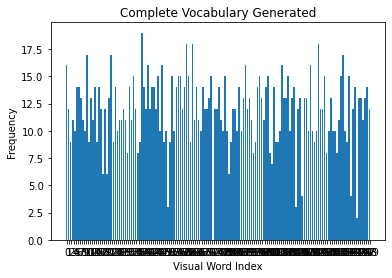

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 38.54574918746948 seconds ---


In [43]:
# train_path = "inputs/dataset/train"
# test_path = "inputs/dataset/test"

train_path = "Task2_data/A1/Objects_Dataset_Images/train"
test_path = "Task2_data/A1/Objects_Dataset_Images/test"
no_clusters = 150
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


### Testing and Data Prepration <a name="bovw_test"></a>

In [44]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "accordion",
        "1": "dollar_bill",
        "2": "motorbike",
        "3": "soccer_ball"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("accordion" in img_path):
                true.append("accordion")
            elif("dollar_bill" in img_path):
                true.append("dollar_bill")
            elif("motorbike" in img_path):
                true.append("motorbike")
            else:
                true.append("soccer_ball")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")

    report(true, predictions)
    print("Accuracy report generated.")
    print("Execution done.")

Test images path detected.
Test images classified.
Confusion matrix, without normalization
Normalized confusion matrix


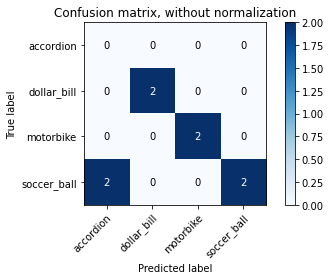

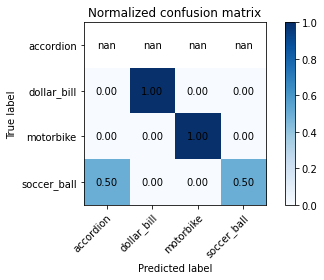

Confusion matrixes plotted.
accuracy score: 0.750
Accuracy calculated.
              precision    recall  f1-score   support

   accordion       0.00      0.00      0.00         0
 dollar_bill       1.00      1.00      1.00         2
   motorbike       1.00      1.00      1.00         2
 soccer_ball       1.00      0.50      0.67         4

    accuracy                           0.75         8
   macro avg       0.75      0.62      0.67         8
weighted avg       1.00      0.75      0.83         8



True Positive Rate:  [nan 1.  1.  0.5]
True Negative Rate:  [0.25 0.   0.   0.  ]
Accuracy report generated.
Execution done.
--- 1.8057541847229004 seconds ---


In [45]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

## **Flower Data Classification**

**Split Data in Train and Test/Val**

In [20]:
# run if splitting required
# splitfolders.ratio("Task2_data/A1/flower_photos/", output="Task2_data/A1/flower_photos_split/",
#                    seed=123, ratio=(.8, .2), group_prefix=None)

### BoVW Utils

In [46]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (2934 / (5 * 639)),
        1: (2934 / (5 * 559)),
        2: (2934 / (5 * 512)),
        3: (2934 / (5 * 718)),
        4: (2934 / (5 * 506))
    }

    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def report(true, predictions):
    print (classification_report(true, predictions))

In [47]:
# count no. of images in each class
# folder_path = 'Task2_data/A1/flower_photos_split/train/' 
# os.listdir(folder_path)
# for f in os.listdir(folder_path):
#   # print(folder_path+f)
#   # files=folder_path+f+""
#   print(f, len(glob(folder_path+f+"/*.jpg")))

## Training and Data Prepration

In [48]:

def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 5
    image_count = len(images)

    for img_path in images:
        if("daisy" in img_path):
            class_index = 0
        elif("dandelion" in img_path):
            class_index = 1
        elif("roses" in img_path):
            class_index = 2
        elif("sunflowers" in img_path):
            class_index = 3
        else:
          class_index = 4
        #print(train_labels, class_index)
        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")
    
    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [ ]:
train_path = "Task2_data/A1/flower_photos_split/train/"
test_path = "Task2_data/A1/flower_photos_split/val/"
no_clusters = 250
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


Train images path detected.


In [ ]:
import joblib
joblib.dump(kmeans, "Task2_data/A1/flower_photos_split/model_250_clust.sav")

['Task2_data/A1/flower_photos_split/model_250_clust.sav']

### Training and Data preparation

In [ ]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "daisy",
        "1": "dandelion",
        "2": "roses",
        "3": "sunflowers",
        "4": "tulips"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("daisy" in img_path):
                true.append("daisy")
            elif("dandelion" in img_path):
                true.append("dandelion")
            elif("roses" in img_path):
                true.append("roses")
            elif("sunflowers" in img_path):
                true.append("sunflowers")
            else:
                true.append("tulips")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")

    report(true, predictions)
    print("Accuracy report generated.")
    print("Execution done.")

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[ 65  25   9  16  12]
 [ 13 123  14   9  21]
 [ 13  24  47  11  34]
 [ 16  19  16  69  20]
 [ 21  23  33  14  69]]
Normalized confusion matrix
[[0.51 0.2  0.07 0.13 0.09]
 [0.07 0.68 0.08 0.05 0.12]
 [0.1  0.19 0.36 0.09 0.26]
 [0.11 0.14 0.11 0.49 0.14]
 [0.13 0.14 0.21 0.09 0.43]]


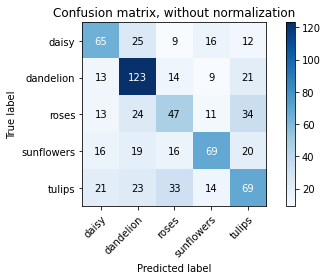

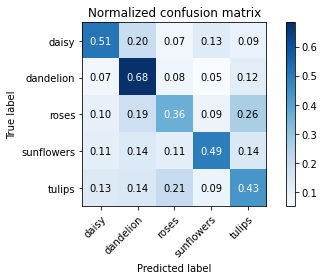

Confusion matrixes plotted.
accuracy score: 0.507
Accuracy calculated.
              precision    recall  f1-score   support

       daisy       0.51      0.51      0.51       127
   dandelion       0.57      0.68      0.62       180
       roses       0.39      0.36      0.38       129
  sunflowers       0.58      0.49      0.53       140
      tulips       0.44      0.43      0.44       160

    accuracy                           0.51       736
   macro avg       0.50      0.50      0.50       736
weighted avg       0.50      0.51      0.50       736

Accuracy report generated.
Execution done.
--- 170.3429400920868 seconds ---


In [ ]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))